In [1]:
import numpy as np
import pandas as pd
from pymc3 import Model, sample, trace_to_dataframe, traceplot
from pymc3 import Normal, HalfCauchy, Beta, Binomial, Deterministic, Exponential, StudentT, Uniform
import theano.tensor as tt

## Load data

In [24]:
previous_elections = pd.read_csv('../data/previous_elections.csv', index_col='date').tail(22)

previous_elections.tail(3)

primary_alp  primary_lnc  primary_oth  tpp_alp  tpp_lnc  \
date                                                                  
2004-10-09        0.376        0.467        0.157    0.473    0.527   
2007-11-24        0.434        0.421        0.145    0.527    0.473   
2010-08-21        0.380        0.433        0.187    0.501    0.499   

            tpp_margin  seats_alp  seats_lnc  seats_oth  seat_margin_pc_majors  
date                                                                            
2004-10-09       0.054       60.0       87.0        3.0               0.183673  
2007-11-24      -0.054       83.0       65.0        2.0              -0.121622  
2010-08-21      -0.002       72.0       72.0        6.0               0.000000

In [25]:
polls = pd.read_csv('../data/polls2016.csv')

polls.tail(3)

bias       std  tpp_margin  tpp_alp  tpp_lnc  start_date    end_date  \
3 -0.01650  0.048175        0.00    0.500    0.500  2016-06-16  2016-06-19   
4 -0.00775  0.025421        0.02    0.490    0.510  2016-06-23  2016-06-26   
5  0.00050  0.022903        0.01    0.495    0.505  2016-06-28  2016-07-01   

       firm  
3  newspoll  
4  newspoll  
5  newspoll

In [9]:
crossbench = pd.read_csv('../data/historic_crossbench_stats.csv', index_col=0)
crossbench_previous = crossbench.query("year < 2016")
crossbench_current = crossbench.loc[2016, :]

crossbench.head(3)

crossbench_before  crossbench_running  crossbench_notrunning  \
year                                                                 
2016                  5                   4                      1   
2013                  5                   3                      2   
2010                  3                   3                      0   

      crossbench_retain  crossbench_gain  total_seats  gain_opportunities  
year                                                                       
2016                  4                1          150                 146  
2013                  3                2          150                 147  
2010                  3                2          150                 147

## Specify and run model (this can take a while)

In [13]:
with Model() as full_model:

    # tpp2seat priors
    tpp2seat_intercept = Normal('tpp2seat_intercept', 0, sd=10)
    tpp2seat_slope = Normal('tpp2seat_slope', 0, sd=10)
    tpp2seat_sigma = HalfCauchy('tpp2seat_sigma', 1)

    tpp2seat_mu = tpp2seat_intercept + tpp2seat_slope * previous_elections['tpp_margin'].values

    # tpp2seat likelihood
    tpp2seat_like = Normal('tpp2seat_like', tpp2seat_mu, sd = tpp2seat_sigma, observed = previous_elections['seat_margin_pc_majors'].values)

    # tpp_margin prior
    tpp_margin = Uniform('tpp_margin', lower=-1, upper=1)

    errors = polls['tpp_margin'].values - tpp_margin

    # tpp_margin likelihood
    tpp_margin_like = Normal('tpp_margin_like', errors, sd = polls['std'].values, observed = polls['bias'].values)

    # seat_margin calculations
    seat_margin_mu = tpp2seat_intercept + tpp2seat_slope * tpp_margin
    seat_margin_pc = Normal('seat_margin_pc', seat_margin_mu, sd = tpp2seat_sigma)

    p_retain = Beta('p_retain', alpha=1, beta=1)
    crossbench_retain_like = Binomial('crossbench_retain_like', n=crossbench_previous['crossbench_running'].values, p=p_retain, observed=crossbench_previous['crossbench_retain'].values)
    crossbench_retain = Binomial('crossbench_retain', n=crossbench_current['crossbench_running'], p=p_retain)

    p_gain = Beta('p_gain', alpha=1, beta=1)
    crossbench_gain_like = Binomial('crossbench_gain_like', n=crossbench_previous['gain_opportunities'].values, p=p_gain, observed=crossbench_previous['crossbench_gain'].values)
    crossbench_gain = Binomial('crossbench_gain', n=crossbench_current['gain_opportunities'], p=p_gain)

    crossbench_total = Deterministic('crossbench_total', crossbench_gain + crossbench_retain)
    majors_seats = (150.0 - crossbench_total)
    
    seat_margin_temp = majors_seats * seat_margin_pc
    alp_seats = Deterministic('alp_seats', tt.round((majors_seats/2.0) - (seat_margin_temp/2.0)).astype('int8'))
    lnc_seats = Deterministic('lnc_seats', tt.round((majors_seats/2.0) + (seat_margin_temp/2.0)).astype('int8'))

    majors_seat_margin = Deterministic('majors_seat_margin', lnc_seats - alp_seats)
    model_sample = sample(2000, chains=3,  tune=1400, progressbar=True)

Multiprocess sampling (3 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [crossbench_gain]
>>Metropolis: [crossbench_retain]
>NUTS: [p_gain, p_retain, seat_margin_pc, tpp_margin, tpp2seat_sigma, tpp2seat_slope, tpp2seat_intercept]
Sampling 3 chains: 100%|██████████| 10200/10200 [00:23<00:00, 435.75draws/s]
The number of effective samples is smaller than 25% for some parameters.


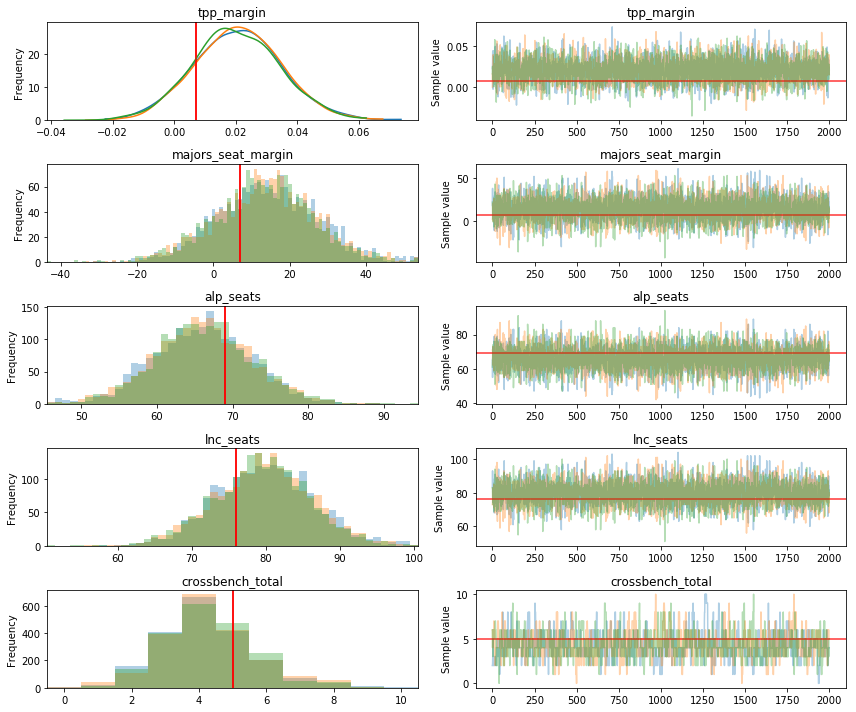

In [17]:
_ = traceplot(model_sample, var_names=['tpp_margin', 'majors_seat_margin', 'alp_seats', 'lnc_seats', 'crossbench_total'], lines={'majors_seat_margin':7, 'alp_seats':69, 'lnc_seats':76, 'crossbench_total':5, 'tpp_margin':0.0072})

## Compare with actual result

In [23]:
print('Actual result: Coalition win\n{:2} LNC seats, {:2} ALP seats, {:2} Crossbench seats'.format(76, 69, 5))

print('Our model:')
print('{:2.1%} chance LNC win'.format((model_sample['lnc_seats']>=75).mean()))
print('{:2.1%} chance hung parliament'.format(((model_sample['lnc_seats']<75) & (model_sample['alp_seats']<75)).mean()))
print('{:2.1%} chance ALP win'.format((model_sample['alp_seats']>=75).mean()))

df = trace_to_dataframe(model_sample)

alp, lnc, cross = df.groupby(['alp_seats', 'lnc_seats', 'crossbench_total']).size().sort_values(ascending=False).idxmax()

print('Our most likely result: {:2} LNC seats, {:2} ALP seats, {:2} Crossbench seats'.format(lnc, alp, cross))

Actual result:
Coalition win, 76 LNC seats, 69 ALP seats,  5 Crossbench seats
Our model:
78.2% chance LNC win
12.0% chance hung parliament
9.8% chance ALP win
Our most likely result: 79 LNC seats, 67 ALP seats,  4 Crossbench seats
